In [10]:
"""
PREDICTION LOOP:
Input: Classifier, Forecaster, Profiles, Label Encoders, Targets {Date,
                                                                  Period,
                                                                  Distribution,
                                                                  Price per volume,
                                                                  Price per volume without promo,
                                                                  Number of Categories,
                                                                  Number of Sub Categories,
                                                                  Category,
                                                                  Sub Category,
                                                                  Brand,
                                                                  }
Output: Predictions over 3Y + Sum over 3Y

"""

'\nPREDICTION LOOP:\nInput: Classifier, Forecaster, Profiles, Label Encoders, Targets {Date,\n                                                                  Period,\n                                                                  Distribution,\n                                                                  Price per volume,\n                                                                  Price per volume without promo,\n                                                                  Number of Categories,\n                                                                  Number of Sub Categories,\n                                                                  Category,\n                                                                  Sub Category,\n                                                                  Brand,\n                                                                  }\nOutput: Predictions over 3Y + Sum over 3Y\n\n'

In [44]:
import pickle
import json
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb


In [12]:
PATH_TO_INPUTS = 'assets/'

In [13]:
"""Classifier, Forecaster"""
classifier = pickle.load(open(PATH_TO_INPUTS + 'classifier_USA.sav', 'rb'))

forecaster = lgb.Booster(model_file=PATH_TO_INPUTS + 'forecaster_USA.txt')

In [14]:
"""Profiles"""
profiles = pd.read_csv(PATH_TO_INPUTS+"profiles_USA.csv")

In [15]:
"""Label Encoders"""
le_brand = pickle.load(open(PATH_TO_INPUTS + 'encoder_brand_USA.pkl', 'rb'))
le_sub_cat = pickle.load(open(PATH_TO_INPUTS + 'encoder_sub_cat_USA.pkl', 'rb'))
le_cat = pickle.load(open(PATH_TO_INPUTS + 'encoder_cat_USA.pkl', 'rb'))

In [129]:
"""Targets"""
with open(PATH_TO_INPUTS + 'predictions_targets_USA.json', 'r') as f:
        targets = json.load(f)['targets']

target = targets[1]

In [130]:
def create_left_inputs(static_inputs):
    """
    """
    dt = static_inputs['Date']
    pd_dt = pd.Timestamp(dt)
    
    second_left_inputs = [static_inputs['Distribution'], 
                          static_inputs['Price per volume'], 
                          static_inputs['Price per volume without promo'], 
                          static_inputs['Number of Categories'], 
                          static_inputs['Number of Sub Categories']]
    
    left_inputs_bis = [static_inputs['Category'],
                       static_inputs['Sub Category'],
                       static_inputs['Brand']]

    left_inputs = [static_inputs['Period'],
                   pd_dt.weekofyear, 
                   pd_dt.is_month_end, 
                   pd_dt.is_month_start] + left_inputs_bis + second_left_inputs
    
    return left_inputs

def update_sample_and_forecast(xgb, sales_lag, 
                               roll_mean, lags, alphas, 
                               static_inputs, period=39, weeks_per_period=1):
    """
    """

    forecasts, samples = [], []
    len_lags = len(lags)
    index_lags = [l-1 for l in lags]
        
    tdelta = dt.timedelta(weeks=weeks_per_period)
    static_inputs['Date'] += tdelta
    left_inputs = create_left_inputs(static_inputs)
    #right_inputs = create_ohe_inputs(*cat_info, ohe_columns=ohe_columns)
    sales_lag = np.log1p(sales_lag)
    
    for p in range(period):
        sales_roll_mean = []
        sales_emw = {alpha:[] for alpha in alphas}
        
        # Compute Roll mean
        for rm in roll_mean:
            df_tmp = pd.DataFrame(sales_lag).apply(lambda x: x.shift(-1).rolling(rm, min_periods=2, win_type="triang").mean()) #+ random_noise(df)
            sales_roll_mean.append(df_tmp.iloc[rm-1].values[0])
            
        # Compute EMW
        for k in alphas:
            for lag in lags:
                df_tmp = pd.DataFrame(sales_lag).apply(lambda x: x.shift(-1*lag).ewm(alpha=k).mean())
                sales_emw[k].append(df_tmp.iloc[0].values[0])
                
        # Concat Sample with static inputs, roll mean, emw, and one hot encodings
        sample = left_inputs + sales_lag[index_lags].tolist() + sales_roll_mean
        for k in alphas:
            sample += sales_emw[k]
        #sample += right_inputs
                
        # Predict next month sales using XGB
        
        
        sales_hat = xgb.predict(np.expand_dims(sample, 0))[0]
        
        samples.append(sample)
    
        sales_lag = np.insert(sales_lag, 0, sales_hat)
        sales_lag = sales_lag[:-1]
        
        sales_hat = np.expm1(sales_hat)
        forecasts.append(sales_hat)

        static_inputs['Period'] += 1
        static_inputs['Date'] += tdelta
        left_inputs = create_left_inputs(static_inputs)
        
    #df_forecasts = pd.DataFrame(np.hstack((np.array(samples), np.array(forecasts)[:, np.newaxis])), columns=list(X_train.columns) + ['Y'])
    df_forecasts = np.array(forecasts)
    return df_forecasts

In [131]:
def pred(forecaster, classifier, profiles, le_brand, le_cat, le_sub_cat, target):
    """Find cluster and profile
    """
    classifier_inputs = {
        'Number of Categories' : target['Number of Categories'], 
        'Number of Sub Categories' : target['Number of Sub Categories'], 
        'min Distribution' : target['Distribution'],
        'max Distribution' : target['Distribution'], 
        'mean Distribution' : target['Distribution'], 
        'std Distribution' : target['Distribution'],
        'min Price' : target['Price per volume'], 
        'max Price' : target['Price per volume'], 
        'mean Price' : target['Price per volume'], 
        'std Price' : target['Price per volume']}
    
    cluster = classifier.predict(pd.DataFrame(classifier_inputs, index=[0]))
    print(f'predicted cluster: {cluster}')
    """Predict
    """
    target['Date'] = dt.datetime.fromisoformat(target['Date'])
    target['Brand'] = le_brand.transform([target['Brand']])
    target['Category'] = le_cat.transform([target['Category']])
    target['Sub Category'] = le_sub_cat.transform([target['Sub Category']])

    primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199]
    alphas_list = [0.95, 0.9, 0.8, 0.7, 0.5]

    for i in profiles.keys():
        profile = profiles[i]
        #profile = profiles[str(int(cluster[0]))]
        forecasts = update_sample_and_forecast(forecaster, profile.values[::-1],
                                primes, primes, alphas_list, 
                                target, period=600, weeks_per_period=1)
        print(i)
        print(sum(forecasts[:300])/1000)
        sns.lineplot(data=forecasts)
        plt.show()

    return forecasts

predicted cluster: [2.]


/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/numpy/lib/shape_base.py:591: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a)


4
427014.71650016133


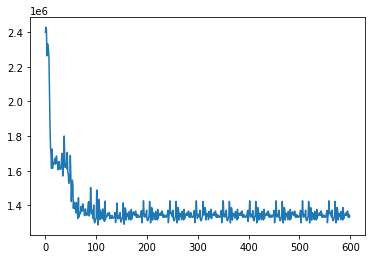

/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/numpy/lib/shape_base.py:591: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a)


3
814.5994170369171


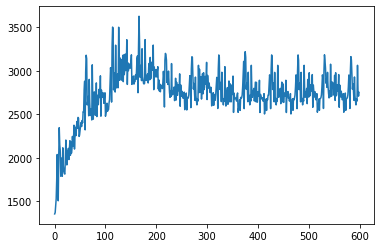

/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/numpy/lib/shape_base.py:591: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a)


1
974.1902130661567


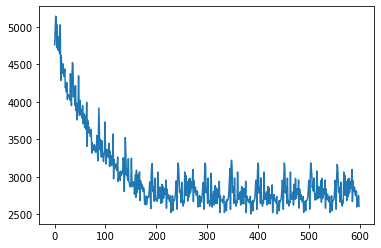

/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/numpy/lib/shape_base.py:591: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a)


0
1722.723533319151


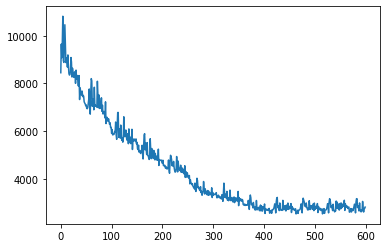

/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages/numpy/lib/shape_base.py:591: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a)


2
10476.281311041741


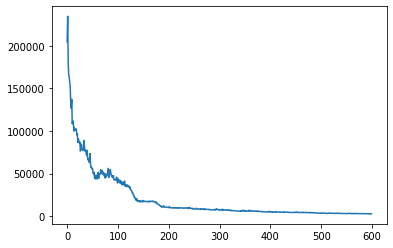

In [132]:

forecasts = pred(forecaster, classifier, profiles, le_brand, le_cat, le_sub_cat, target)
#sns.lineplot(data=forecasts)


                           

In [20]:
# print(le_cat.transform(['CLASSIC SPREADS'])[0],
#       le_sub_cat.transform(['CLASSIC SPREADS'])[0],
#       le_brand.transform(['THE LAUGHING COW'])[0])


In [61]:
from datamanager.DM_USA import DM_USA

In [62]:
data_manager = DM_USA()

page 1 / 13
page 2 / 13
page 3 / 13
page 4 / 13
page 5 / 13
page 6 / 13
page 7 / 13
page 8 / 13
page 9 / 13
page 10 / 13
page 11 / 13
page 12 / 13
page 13 / 13


In [117]:
df_gourmet = data_manager.df[data_manager.df['Sub Category']=='CLASSIC SPREADS']

#plt.figure(figsize=(20, 20))
#sns.lineplot(data = df_gourmet, x='Date', y='Price per volume', hue='Brand')

In [93]:
print(df_gourmet.Distribution.mean())

print(df_gourmet['Price per volume'].median())

3.736206626248013
8.692


In [126]:
df_gourmet.groupby('Brand')['Sales in volume'].sum().sort_values(ascending=False)/1000

Brand
MERKTS            12600.546467
PRIVATE LABEL     12276.724772
PRESIDENT         10343.680965
KAUKAUNA           8785.860921
OLD FASHIONED       3510.32034
                      ...     
TIROLEZ               0.032164
TASSOS                 0.01025
BAYOU BROTHERS         0.00217
PINELAND FARMS        0.001567
SAVORY MOMENTS        0.000448
Name: Sales in volume, Length: 189, dtype: object

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_63546/3917398774.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=data_manager.df[data_manager.df['Sub Category']=='CLASSIC SPREADS'][data_manager.df.Brand == 'MERKTS'], x='Date', y='Sales in volume')


<AxesSubplot:xlabel='Date', ylabel='Sales in volume'>

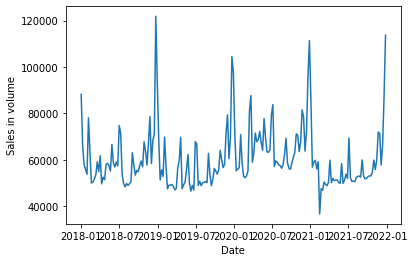

In [128]:
sns.lineplot(data=data_manager.df[data_manager.df['Sub Category']=='CLASSIC SPREADS'][data_manager.df.Brand == 'MERKTS'], x='Date', y='Sales in volume')